In [1]:
import os
import sys
sys.path.append('/home/biswajitsc_google_com/nfs_mount/hierarchicalforecasting/')

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pickle
import seaborn as sns

In [3]:
import data_loader

pkl_path = '../data/m5/data.pkl'
with open(pkl_path, 'rb') as fin:
    tree, num_ts, ts_data, feats = pickle.load(fin)
# ts_means = np.mean(ts_data, axis=1).reshape((-1, 1))
# ts_data /= ts_means

variations = ts_data[:, 1:] - ts_data[:, :-1]
variations = np.mean(variations**2, axis=1)
variations = np.sqrt(variations).reshape((-1, 1))
ts_data = ts_data / variations

print(feats.shape, ts_data.shape)

(9, 1941) (3060, 1941)


0


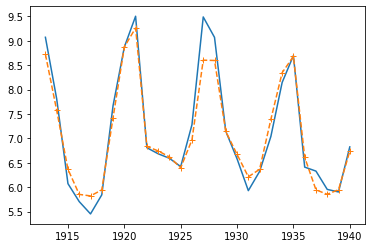

In [63]:
x = range(1941)
for i in range(1):
    idx = np.random.choice(tree.levels[0])
    print(idx)
    plt.plot(x[-28:], ts_data[idx, -28-30:-30])
    plt.plot(x[-28:], evals[-28:, idx], '+--')

In [3]:
file_path = '../data/m5/sales_train_evaluation.csv'
with open(file_path, 'r') as fin:
    sales_data = pd.read_csv(fin, ',')

In [4]:
agg = {}

for item in sales_data.itertuples():
    cat = item[3]
    vals = np.asarray(item[7:])
    agg[cat] = agg.get(cat, 0) + vals

print(agg.keys())

dict_keys(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3'])


In [2]:
evals = np.load('evals.npy')
evals.shape

(28, 3060)

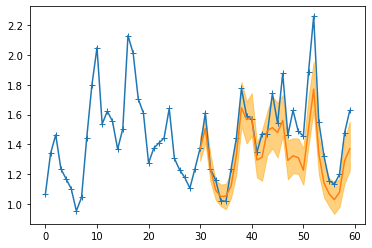

In [44]:
n = 60
x = list(range(n))
ratios = []
# keys = agg.keys()
keys = ['FOODS_2']
for key in keys:

    nid = tree.node_id[key]

    # y = agg[key][-n:]
    y_ = ts_data[nid][-n:]
    y_pred = evals[:,:,nid]
    y_10p = np.percentile(y_pred, 10, axis=0)
    y_90p = np.percentile(y_pred, 90, axis=0)
    y_50p = np.percentile(y_pred, 50, axis=0)
    pred_hor = evals.shape[1]

    # y = y / np.mean(y)
    # y_ = y_ / np.mean(y_)
    plt.plot(x, y_, '-+')
    plt.plot(x[-pred_hor:], y_50p)
    plt.fill_between(x[-pred_hor:], y_10p, y_90p, alpha=0.5, color='orange')
    # ratio = np.mean(y) / np.mean(y[:-30])
    # if ratio > 0 and ratio < 20:
    #     ratios.append(ratio)
# plt.hist(ratios, bins=100)
# for i in range(1, 10):
#     y_ = ts_data[tree.node_id[f'HOBBIES_1_00{i}']][-n:]
#     y_ = y_/ np.mean(y_)
#     plt.plot(x, y_, '-*')

In [65]:
ratios

[0.3542659279778394]

In [5]:
sales_data

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [7]:
features_path = '../data/m5/calendar.csv'
with open(features_path, 'r') as fin:
    features = pd.read_csv(features_path, ',')

In [15]:
np.asarray(features[['wday', 'month', 'snap_CA', 'snap_TX', 'snap_WI']][:1941])

array([[1, 1, 0, 0, 0],
       [2, 1, 0, 0, 0],
       [3, 1, 0, 0, 0],
       ...,
       [7, 5, 0, 0, 0],
       [1, 5, 0, 0, 0],
       [2, 5, 0, 0, 0]])

In [64]:
feats_2 = features['event_type_1'][:1941]
cats = list(feats_2.unique())
cats.remove(np.nan)

feats_2 = [[''] if isinstance(f, float) else [f] for f in feats_2]
enc = OneHotEncoder(categories=[cats,], handle_unknown='ignore', sparse=False)
feats_2 = enc.fit_transform(feats_2)
print(feats_2[:30])

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [61]:
features[features['event_type_1'] == 'Cultural']
features.iloc[-30:]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1939,2016-05-21,11617,Saturday,1,5,2016,d_1940,NaN,NaN,NaN,NaN,0,0,0
1940,2016-05-22,11617,Sunday,2,5,2016,d_1941,NaN,NaN,NaN,NaN,0,0,0
1941,2016-05-23,11617,Monday,3,5,2016,d_1942,NaN,NaN,NaN,NaN,0,0,0
1942,2016-05-24,11617,Tuesday,4,5,2016,d_1943,NaN,NaN,NaN,NaN,0,0,0
1943,2016-05-25,11617,Wednesday,5,5,2016,d_1944,NaN,NaN,NaN,NaN,0,0,0
1944,2016-05-26,11617,Thursday,6,5,2016,d_1945,NaN,NaN,NaN,NaN,0,0,0
1945,2016-05-27,11617,Friday,7,5,2016,d_1946,NaN,NaN,NaN,NaN,0,0,0
1946,2016-05-28,11618,Saturday,1,5,2016,d_1947,NaN,NaN,NaN,NaN,0,0,0
1947,2016-05-29,11618,Sunday,2,5,2016,d_1948,NaN,NaN,NaN,NaN,0,0,0
1948,2016-05-30,11618,Monday,3,5,2016,d_1949,MemorialDay,National,NaN,NaN,0,0,0
